# Beyond Heatmaps: Mapping Two Variables with Plotly in Public Health  
**Interactive Maps Exploring Relationships Between Fermented Vegetables and Covid-19 Mortality Rates**

by Xin (David) Zhao  
updated on April 21, 2025

In 2020, a [preprint](https://www.medrxiv.org/content/10.1101/2020.07.06.20147025v1) suggested that fermented vegetable consumption might be inversely associated with COVID-19 mortality in Europe—even after adjusting for confounding factors. I wanted to explore that hypothesis using public data and an interactive map.

## Load Modules

In [ ]:
# Core data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive map visualization
import plotly.express as px # Creating chorppleth and scatter_geo maps
import plotly.graph_objects as go # Overalaying plot layers and annotation

# For geospatial data 
import requests # Fetching GeoJSON data from remote URL 
import json # Parsing JSON data
import pycountry # Mapping country names to ISO alpha-3 codes

# For exporting maps
import plotly.io as pio # Exporting Plotly figures as HTML
import kaleido  # Saving Plotly maps as static images (optional)

: 

## Preparing the Epidemiological Data

### COVID-19 Mortality Rates Dataset

In [234]:
covid_death_pop_df = pd.read_csv('covid_mortality_rate.csv')

In [235]:
covid_death_pop_df.head()

,Country,Year,Population,Deaths,Death Rate
0,European Economic Area (EU28 - 2013-2020 and I...,2020,519811603.0,0.0,0.000000
1,European Union - 27 countries (from 2020),2020,447015600.0,0.0,0.000000
2,Euro area – 20 countries (from 2023),2020,346625682.0,0.0,0.000000
3,Germany,2020,83166711.0,2890473.0,0.034755
4,Germany including former GDR,2020,83166711.0,0.0,0.000000


### Fermented Vegetable Consumption Dataset

In [245]:
avg_consumption_country = pd.read_csv('fermented_food_consumption.csv')

In [246]:
avg_consumption_country.head()

,Country,Average Consumption
0,Austria,2.660731
1,Belgium,0.454854
2,Bosnia and Herzegovina,5.906935
3,Bulgaria,1.235104
4,Croatia,3.958930


### Getting Geospatial Data

In [247]:
# Fetch GeoJSON for Europe
import requests
import json
    

In [248]:
# URL for countries' GeoJSON data
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"

# Fetch the data
response = requests.get(url)
geojson_data = response.json()

In [249]:
targeted_countries = food_df['Country'].unique().tolist()
print(len(targeted_countries))

23


In [250]:
# Filter the geojson for EU 
eu_geojson = {
    "type": "FeatureCollection",
    "features": [
        feature for feature in geojson_data["features"]
        if feature["properties"]["name"] in targeted_countries
    ]
}

In [251]:
len(eu_geojson['features'])

21

In [252]:
# Identify EU countries in the eu_geojson
eu_countries_geojson = [feature['properties']['name'] for feature in eu_geojson['features']] 

In [253]:
print(eu_countries_geojson)

['France', 'Czechia', 'Germany', 'Estonia', 'Latvia', 'Sweden', 'Finland', 'Belgium', 'Romania', 'Hungary', 'Poland', 'United Kingdom', 'Greece', 'Austria', 'Netherlands', 'Croatia', 'Slovenia', 'Bulgaria', 'Montenegro', 'Bosnia and Herzegovina', 'Portugal']


In [254]:
# Save en_countries_geojson as dataframe 
eu_countries_df = pd.DataFrame(eu_countries_geojson, columns=['Country']) 

### Merging Multiple Source Data

In [255]:
# Merge eu_countries_df with avg_consumption_country on Country
eu_avg_consumption_country = eu_countries_df.merge(avg_consumption_country, on='Country', how='left') 

In [256]:
eu_avg_consumption_country.head()

,Country,Average Consumption
0,France,1.135681
1,Czechia,5.578666
2,Germany,1.552563
3,Estonia,3.232856
4,Latvia,4.280254


In [257]:
# Merge eu_avg_consumption_country with covid_death_pop_df on Country
eu_avg_consumption_covid_death_pop_df = eu_avg_consumption_country.merge(covid_death_pop_df, on='Country', how='left')

## Visualizing Maps

### Choropleth Map: Fermented Vegetable Consumption in EU countries

To change the colors of the areas (countries) separately from the bubbles, use px.choropleth() for the country colors and px.scatter_geo() for the bubbles, then overlay them using go.Figure().

In [260]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

In [261]:
eu_avg_consumption_covid_death_pop_df.columns 

Index(['Country', 'Average Consumption', 'Year', 'Population', 'Deaths',
       'Death Rate'],
      dtype='object')

In [262]:
eu_avg_consumption_covid_death_pop_df.head()

,Country,Average Consumption,Year,Population,Deaths,Death Rate
0,France,1.135681,2020,67473651.0,9284524.0,0.137602
1,France,1.135681,2021,67728568.0,38470807.0,0.568014
2,France,1.135681,2022,67957053.0,54424558.0,0.800867
3,France,1.135681,2023,68172977.0,11230468.0,0.164735
4,Czechia,5.578666,2020,10693939.0,600899.0,0.056191


In [263]:
# Drop rows with Inf values in Death Rate column
eu_avg_consumption_covid_death_pop_df = eu_avg_consumption_covid_death_pop_df[eu_avg_consumption_covid_death_pop_df['Death Rate'] != np.inf]

### Getting ISO country codes

In [264]:
import pycountry

# List of EU countries
eu_countries = eu_avg_consumption_covid_death_pop_df['Country'].unique().tolist()   

# Dictionary of country names and their corresponding alpha_3 codes
country_alpha3 = {}
for country in eu_countries:
    try:
        country_data = pycountry.countries.get(name=country)
        # print(country_data.alpha_3)
        country_alpha3[country] = country_data.alpha_3
    except:
        print(f"{country} not found")

print(country_alpha3)


{'France': 'FRA', 'Czechia': 'CZE', 'Germany': 'DEU', 'Estonia': 'EST', 'Latvia': 'LVA', 'Sweden': 'SWE', 'Finland': 'FIN', 'Belgium': 'BEL', 'Romania': 'ROU', 'Hungary': 'HUN', 'Poland': 'POL', 'United Kingdom': 'GBR', 'Greece': 'GRC', 'Austria': 'AUT', 'Netherlands': 'NLD', 'Croatia': 'HRV', 'Slovenia': 'SVN', 'Bulgaria': 'BGR', 'Montenegro': 'MNE', 'Bosnia and Herzegovina': 'BIH', 'Portugal': 'PRT'}


In [265]:
# Add ISO Alpha-3 codes to eu_avg_consumption_covid_death_pop_df
eu_avg_consumption_covid_death_pop_df['iso_alpha'] = eu_avg_consumption_covid_death_pop_df['Country'].map(country_alpha3)


### Subset the Data in 2020

In [266]:
data_map_2020 = eu_avg_consumption_covid_death_pop_df[eu_avg_consumption_covid_death_pop_df['Year'] == 2020]

### Drawing the Map

In [ ]:
# Create a Choropleth map (for country colors) based on fermented vegetable consumption
food_map = px.choropleth(
    data_map_2020,  # DataFrame containing the data for the map
    locations="iso_alpha",  # Column with ISO Alpha-3 country codes for mapping
    color="Average Consumption",  # Column to determine the color intensity (fermented vegetable consumption)
    hover_name="Country",  # Column to display as hover text (country names)
    scope="europe",  # Restrict the map to the European region
    projection="natural earth",  # Use the "natural earth" projection for the map
    color_continuous_scale='Plasma'  # Use the "Plasma" color scale for visualizing data
)

food_map.show()


### Bubble Overlay: Covid-19 Mortality Rates

In [ ]:
# Create a scatter geo map (for bubble overlay) based on Covid-19 mortality rates
bubble_map = px.scatter_geo(
    data_map_2020,  # DataFrame containing the data for the map
    locations="iso_alpha",  # Column with ISO Alpha-3 country codes for mapping
    hover_name="Country",  # Column to display as hover text (country names)
    size="Death Rate",  # Column to determine the size of the bubbles (Covid-19 mortality rates)
    scope="europe",  # Restrict the map to the European region
    projection="natural earth",  # Use the "natural earth" projection for the map
    opacity=0.7,  # Set opacity level for better visibility of overlapping bubbles
    size_max=15,  # Set the maximum size for the bubbles
    color_continuous_scale=px.colors.sequential.Plasma  # Use the "Plasma" color scale for visualizing data
)

bubble_map.show()

### Combining Both Layers

In [270]:
# Combine both layers
fig = go.Figure(data=food_map.data + bubble_map.data)

### Fine-Tuning the Map for Clarity and Style

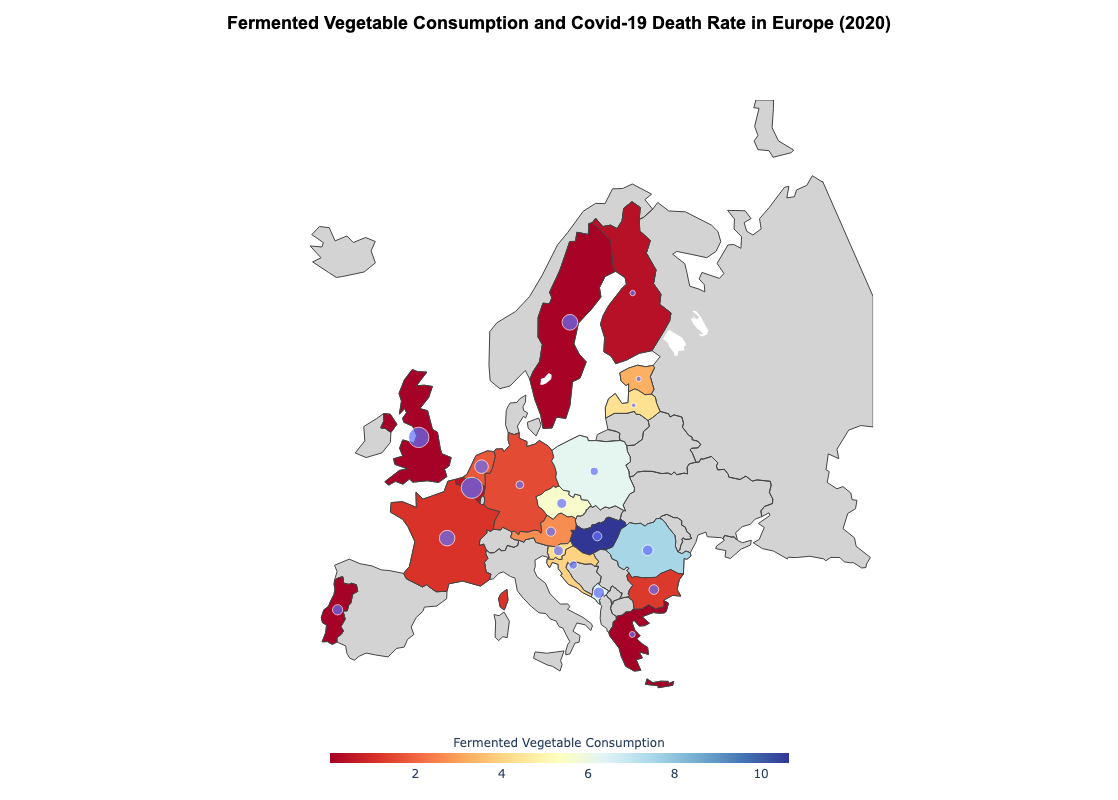

In [ ]:
# Update layout for the combined map
fig.update_geos(
    scope="europe",  # Restrict the map to show only European countries
    showcoastlines=False,  # Hide coastlines for a cleaner look
    showland=True,  # Display land areas
    landcolor="lightgray",  # Set the land color to light gray for better contrast
    projection_scale=1.5  # Adjust the zoom level of the map
)

# Update the color scale for the choropleth layer
fig.update_layout(
    coloraxis_colorbar_title="Fermented Vegetable Consumption",  # Title for the colorbar
    coloraxis_colorscale="RdYlBu",  # Use the "Red-Yellow-Blue" color scale
    width=1200,  # Set the width of the figure
    height=800,  # Set the height of the figure
    coloraxis_colorbar=dict(
        orientation="h",  # Set the colorbar orientation to horizontal
        title="Fermented Vegetable Consumption",  # Title for the colorbar
        title_side="top",  # Position the title above the colorbar
        title_font_size=12,  # Set the font size for the title
        thickness=10,  # Adjust the thickness of the colorbar
        len=0.5,  # Set the relative length of the colorbar
        x=0.25,  # Position the colorbar horizontally (relative to the figure)
        y=0.95,  # Position the colorbar vertically (relative to the figure)
    )
)

# Update the hover template for the scatter layer
fig.update_layout(
    title=dict(
        text="Fermented Vegetable Consumption and Covid-19 Death Rate in Europe (2020)",  # Title of the map
        x=0.5,  # Center the title horizontally
        y=0.98,  # Position the title slightly above the colorbar
        xanchor="center",  # Anchor the title at the center horizontally
        yanchor="top",  # Anchor the title at the top vertically
        font=dict(
            size=18,  # Set the font size for the title
            family="Arial, sans-serif",  # Use a professional font family
            color="black",  # Set the font color to black
            weight="bold"  # Make the title bold for emphasis
        )
    )
)

# Update the colorbar layout again (optional adjustment)
fig.update_layout(
    coloraxis_colorbar=dict(
        orientation="h",  # Keep the colorbar horizontal
        x=0.5,  # Center the colorbar horizontally below the map
        y=-0.15,  # Move the colorbar below the map
        len=0.5,  # Set the relative length of the colorbar
        thickness=10  # Adjust the thickness of the colorbar
    )
)

# Display the final map
fig.show()

### Annotating Country Names on the Map

In [272]:
# Annotate country names on the map

import pandas as pd

# Create the DataFrame
country_data = pd.DataFrame({
    "Country": ["Austria", "Belgium", "Bulgaria", "Bosnia and Herzegovina", "Germany", "Estonia", "Finland", "France", "United Kingdom", "Greece", "Croatia", "Hungary", "Latvia", "Montenegro", "Netherlands", "Poland", "Portugal", "Romania", "Slovenia", "Sweden"],
    "ISO3": ["AUT", "BEL", "BGR", "BIH", "DEU", "EST", "FIN", "FRA", "GBR", "GRC", "HRV", "HUN", "LVA", "MNE", "NLD", "POL", "PRT", "ROU", "SVN", "SWE"],
    "Lat": [47.5162, 50.5039, 42.7339, 43.9159, 51.1657, 58.5953, 61.9241, 46.6034, 55.3781, 39.0742, 45.1, 47.1625, 56.8796, 42.7087, 52.1326, 51.9194, 39.3999, 45.9432, 46.1512, 60.1282],
    "Lon": [14.5501, 4.4699, 25.4858, 17.6791, 10.4515, 25.0136, 25.7482, 1.8883, -3.4360, 21.8243, 15.2, 19.5033, 24.6032, 19.3744, 5.2913, 19.1451, -8.2245, 24.9668, 14.9955, 18.6435]
})

# Display the DataFrame
print(country_data)

                   Country ISO3      Lat      Lon
0                  Austria  AUT  47.5162  14.5501
1                  Belgium  BEL  50.5039   4.4699
2                 Bulgaria  BGR  42.7339  25.4858
3   Bosnia and Herzegovina  BIH  43.9159  17.6791
4                  Germany  DEU  51.1657  10.4515
5                  Estonia  EST  58.5953  25.0136
6                  Finland  FIN  61.9241  25.7482
7                   France  FRA  46.6034   1.8883
8           United Kingdom  GBR  55.3781  -3.4360
9                   Greece  GRC  39.0742  21.8243
10                 Croatia  HRV  45.1000  15.2000
11                 Hungary  HUN  47.1625  19.5033
12                  Latvia  LVA  56.8796  24.6032
13              Montenegro  MNE  42.7087  19.3744
14             Netherlands  NLD  52.1326   5.2913
15                  Poland  POL  51.9194  19.1451
16                Portugal  PRT  39.3999  -8.2245
17                 Romania  ROU  45.9432  24.9668
18                Slovenia  SVN  46.1512  14.9955


In [273]:
import plotly.graph_objects as go

# Create the country label layer (scattergeo)
country_labels = go.Scattergeo(
    locationmode="ISO-3",
    lon=country_data["Lon"],
    lat=country_data["Lat"],
    text=country_data["Country"],  # Display country names
    mode="text",  # Only text (no markers)
    textfont=dict(size=12, color="black", family="Arial", weight="bold"),  # Adjust font
    textposition="top center",  
    showlegend=False
)

# Add to your existing Plotly figure
fig.add_trace(country_labels)


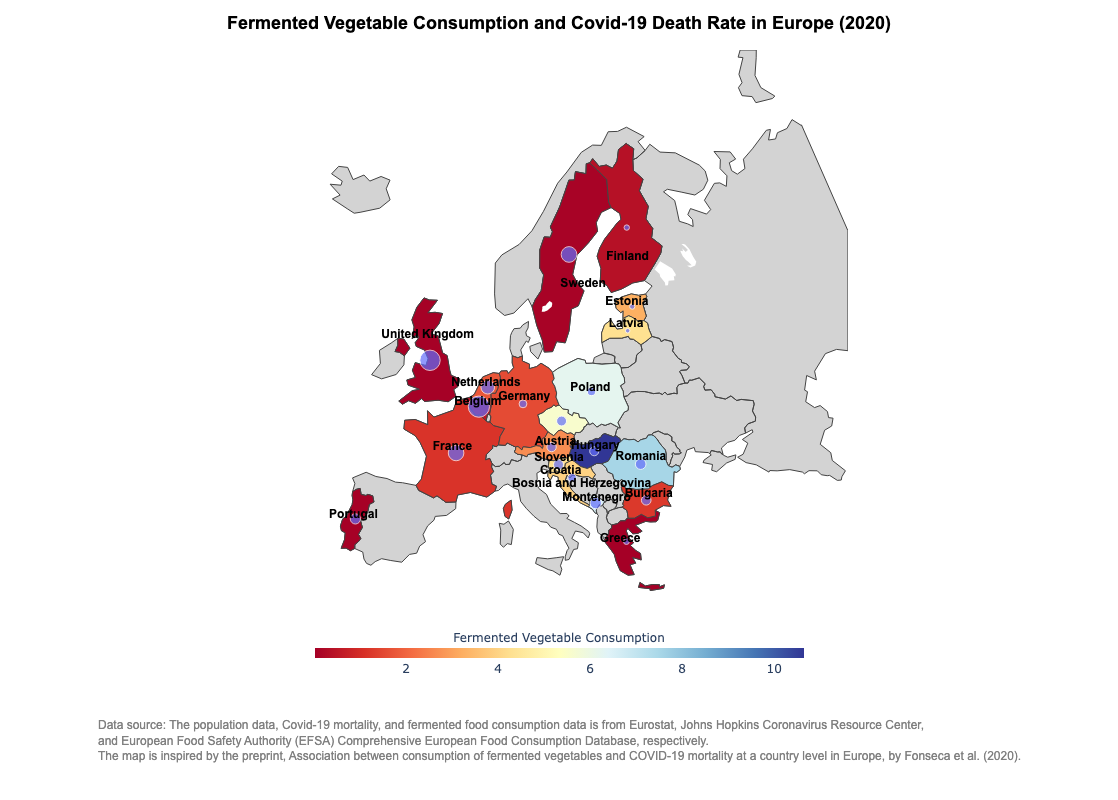

In [ ]:
# Add footnote to the map
fig.update_layout(
    margin=dict(l=50, r=50, t=50, b=200)  # Increase the bottom margin (b) to make space for the footnote
)

# Add an annotation for the data source and inspiration
fig.add_annotation(
    text="Data source: The population data, Covid-19 mortality, and fermented food consumption data is from Eurostat, Johns Hopkins Coronavirus Resource Center,<br>"
         "and European Food Safety Authority (EFSA) Comprehensive European Food Consumption Database, respectively.<br>"
         "The map is inspired by the preprint, Association between consumption of fermented vegetables and COVID-19 mortality at a country level in Europe, by Fonseca et al. (2020).",  # Footnote text
    xref="paper",  # Reference the x-coordinate relative to the entire figure
    yref="paper",  # Reference the y-coordinate relative to the entire figure
    x=0.5,  # Position the annotation horizontally at the center of the figure
    y=-0.3,  # Position the annotation below the figure
    showarrow=False,  # No arrow is needed for the annotation
    font=dict(size=12, color="grey", family="Arial"),  # Set the font size, color, and family for the annotation text
    align="left"  # Align the text to the left for better readability
)

fig.show()

### Exporting the Map

In [275]:
# Save the Plotly figure as HTML file  
pio.write_html(fig, file='index.html', auto_open=True)

In [276]:
pio.write_image(fig, 'fermented_vegetable_consumption_covid_death_rate_europe_2020.png', format='png', width=1200, height=800, scale=2) # Save as PNG